In [134]:
# Third-party Library Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)
from scipy.stats import pearsonr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_columns', 100)

### 1. Read SCM & ERA data

In [135]:
# Read ERA data
era_final = pd.read_csv("files/ERA/processed/era_final_features.csv")
era_raw = pd.read_csv("files/ERA/processed/era_tmean_rain_all_departments.csv").assign(model="ERA", init_month=12)
era_raw_unstructured = pd.read_csv("files/ERA/processed/era_tmean_rain_all_departments_not_structured.csv").assign(model="ERA", init_month=12)

# Read SCM data 
c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
scm = pd.concat([nmme, c3s], ignore_index=True).drop_duplicates().rename(columns={"forecasted_month":"month"})
scm["rain"] = scm["rain"].apply(lambda x: x*1000)

# Read study region polygon
study_region = gpd.read_file("files/shapefiles/study_region.shp")

# Filter SCM data by month and model
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(6, 11) & (scm["model"].isin(['GFDL', 'CCSM4', 'NASA', 'CMCC', 'DWD', 'ECMWF', 'METFR', 'UKMO', 'ECCC', 'NCEP'])))].reset_index(drop=True)

# Filter SCM data by grid cells of study region
scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"], crs="EPSG:4326"))
coordinates = gpd.sjoin(scm[["geometry", "lat", "lon"]].drop_duplicates(), study_region).reset_index(drop=True)[["name", "lat", "lon"]]
scm = scm.merge(coordinates[["lat", "lon"]], on=["lat", "lon"], how="right")

scm.head(2)

,model,year,init_month,month,rain,tmean,lat,lon,geometry
0,GFDL,1993,6,9,1.587734,13.175134,-40.0,-63.0,POINT (-63.00000 -40.00000)
1,GFDL,1993,6,10,1.644671,16.745554,-40.0,-63.0,POINT (-63.00000 -40.00000)


Store variable names:

In [136]:
# Unique SCM
climate_models = scm["model"].unique().tolist()
climate_models.sort()

# Grid cells for final model
features_grid_cells = list(set(["_".join(c.split("_")[1:3]) for c in era_final.columns if ("rain" in c) or ("tmean" in c)]))

# Meteorological indices used by end-of-season model
features = [c for c in era_final.columns if ("rain" in c) or ("tmean" in c)]

# Coordinates as 2d list
coordinates = [c.split("_") for c in features_grid_cells]

# Extract features needed for basis expansion, e.g. Tmean_Oct if Tmean_squared_Oct is used for final model
features_raw = []
new_dict = dict(zip(["tmean", "rain"], [dict.fromkeys(["_".join(c.split("_")[1:3]) for c in features if ("tmean" in c)]), dict.fromkeys(["_".join(c.split("_")[1:3]) for c in features if ("rain" in c)])]))
for var in new_dict:
    for loc in new_dict[var]:
        new_dict[var][loc] = list(set([int(c.split("_")[-1]) for c in features if (var in c) and (loc in c)]))
        for month in new_dict[var][loc]:
            features_raw.append("{}_{}_{}".format(var, loc, month))

### 2. Filter SCM & ERA raw dataset by relevant grid cells

In [137]:
# Filter ERA
era_raw = era_raw.loc[:, ["year", "model", "init_month"] + features_raw]

def filter_grid_cells(df):
    # Filter SCM (keep two neighboring grid cells as well)
    li = []
    df["loc"] = np.nan
    for c in coordinates:
        lat = int(c[0])
        lon = int(c[1])
        
        data = df.loc[((df["lat"] == lat) & (df["lon"] == lon)) | ((df["lat"] == lat-1) & (df["lon"] == lon-1)) 
                    | ((df["lat"] == lat+1) & (df["lon"] == lon+1))].copy()
        
        data.loc[((df["lat"] == lat) & (df["lon"] == lon)), "loc"] = "loc_orig"
        data.loc[((df["lat"] == lat-1) & (df["lon"] == lon-1)), "loc"] = "loc_n1"
        data.loc[((df["lat"] == lat+1) & (df["lon"] == lon+1)), "loc"] = "loc_n2"
        
        data.loc[:, "lat"] = lat
        data.loc[:, "lon"] = lon
        
        li.append(data)

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

In [138]:
scm = filter_grid_cells(scm)

### 3. Bring SCM hindcasts into feature structure

In [139]:
scm_pivot = scm.pivot_table(
                            index=["model", "year", "init_month", "loc"],
                            columns=["lat", "lon", "month"],
                            values=["tmean", "rain"]
                    )
scm_pivot.columns = ["{}_{}_{}_{}".format(c[0], int(c[1]), int(c[2]), c[3]) for c in scm_pivot.columns]
scm_pivot = scm_pivot[features_raw].reset_index()

scm_pivot.head()

,model,year,init_month,loc,tmean_-38_-62_11,tmean_-31_-61_10,rain_-38_-62_11,rain_-31_-61_10,rain_-31_-61_11,rain_-36_-62_9
0,CCSM4,1993,6,loc_n1,19.865289,22.007547,1.442453,2.381513,3.319848,1.224823
1,CCSM4,1993,6,loc_n2,20.579034,22.644968,2.691816,3.317811,3.893459,1.371600
2,CCSM4,1993,6,loc_orig,20.450403,22.388498,2.258088,2.798091,3.445857,1.301647
3,CCSM4,1993,7,loc_n1,19.641229,21.318323,1.431106,2.707965,3.141649,1.437231
4,CCSM4,1993,7,loc_n2,19.969827,22.017175,2.851885,3.527866,4.021517,1.703101


### 4. Adjust Bias

In [149]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """apply bias-adjustment to monthly values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    adjusted_models = []
    for model in climate_models:
        adjusted_init_months = []
        for month in predicted["init_month"].unique().tolist():
            adjusted_cols = []
            for col in features_raw:
                adjusted_years = []
                for year in list(range(1993, 2017)):
                    observations_used_as_reference = observed.loc[(observed["model"] == "ERA") & (observed["year"] != year), col]
                    hindcast_used_as_reference = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month), col]
                    hindcast_to_be_adjusted = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), col].copy()
                    y = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), ["model", "year", "init_month", "loc"]].copy()

                    # Perform bias-adjustment 
                    if (int(col.split("_")[-1]) >= month):
                        bc_col = BiasCorrection(observations_used_as_reference, hindcast_used_as_reference, hindcast_to_be_adjusted)
                        if ("tmean" in col):
                            hindcast_to_be_adjusted = bc_col.correct(method=correction_method)
                            hindcast_to_be_adjusted.name = col
                        elif ("rain" in col):
                            hindcast_to_be_adjusted = hindcast_to_be_adjusted * observations_used_as_reference.mean() / hindcast_used_as_reference.mean()
                        #    hindcast_to_be_adjusted = bc_col.correct(method="normal_mapping")
                            hindcast_to_be_adjusted.name = col

                    hindcast_to_be_adjusted = pd.concat([y, hindcast_to_be_adjusted], axis=1)
                    adjusted_years.append(hindcast_to_be_adjusted)
                adjusted_years = pd.concat(adjusted_years)
                adjusted_cols.append(adjusted_years)
            
            adjusted_cols = pd.concat(adjusted_cols, axis=1)
            adjusted_cols = adjusted_cols.loc[:,~adjusted_cols.columns.duplicated()]
            adjusted_init_months.append(adjusted_cols)
        adjusted_init_months = pd.concat(adjusted_init_months)
        adjusted_models.append(adjusted_init_months)
    adjusted_models = pd.concat(adjusted_models).sort_values(by=["model", "year", "init_month"])
    return adjusted_models

In [150]:
scm_bias_adjusted = adjust_bias(era_raw, scm_pivot, "normal_mapping")
scm_bias_adjusted = scm_bias_adjusted.groupby(["model", "year", "init_month"])[features_raw].mean().reset_index()

scm_bias_adjusted.sample(3)

,model,year,init_month,tmean_-38_-62_11,tmean_-31_-61_10,rain_-38_-62_11,rain_-31_-61_10,rain_-31_-61_11,rain_-36_-62_9
903,METFR,1999,9,16.933138,19.310515,2.859421,4.144563,4.088349,2.241162
1008,NASA,1993,6,16.175011,19.004054,3.476335,5.145994,5.217922,1.669823
637,ECMWF,2003,7,17.416516,19.721323,2.671250,4.917698,4.838406,1.929491


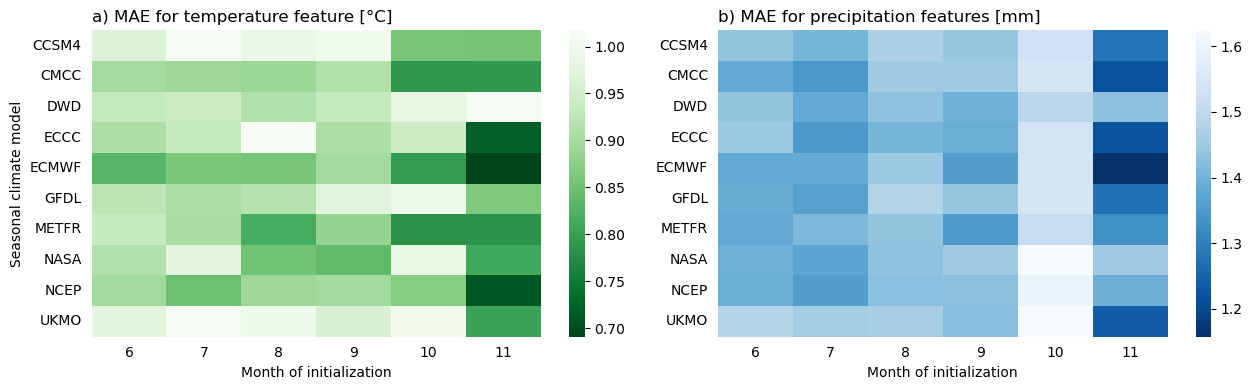

In [237]:
test_features = ['rain_-36_-62_9', 'rain_-31_-61_11', 'rain_-38_-62_11', 'tmean_-38_-62_11']

fig, axs = plt.subplots(1, 2, figsize=(13,4))
axs = axs.ravel()

def compute_scm_mae(df_scm, df_era, features):
    # Calculate error (bias) for each feature
    scm_error = df_scm.groupby(["model", "year", "init_month"])[features].mean().reset_index().sort_values(by=["model", "init_month", "year"]).reset_index(drop=True).copy()
    era_error = pd.concat(len(scm_error["model"].unique()) * len(scm_error["init_month"].unique()) * [df_era.copy()], axis=0, ignore_index=True)[["model", "year", "init_month"] + features]
    scm_error[features] = scm_error[features] - era_error[features]
    scm_error = scm_error.set_index(["model", "init_month"])[features]
    
    # MEAN ABSOLUTE ERROR
    scm_mae = scm_error.copy()
    # 1. Set 0s to Nan so that they are ignored for mean
    scm_mae = scm_mae.replace({0:np.nan})
    # 2. Absolute 
    scm_mae = scm_mae.abs()
    
    return scm_mae


data_plot_pre_ba = compute_scm_mae(scm_pivot, era_raw, features_raw).assign(type="pre BA").set_index("type", append=True)
data_plot_post_ba = compute_scm_mae(scm_bias_adjusted, era_raw, features_raw).assign(type="post BA").set_index("type", append=True)

data_plot = pd.concat([data_plot_pre_ba, data_plot_post_ba], axis=0, ignore_index=False)
# 3. Separate Prec and Tmean
data_plot_tmean = data_plot[[c for c in data_plot.columns if ("tmean" in c)]]
data_plot_rain = data_plot[[c for c in data_plot.columns if ("rain" in c)]]
# 4. Mean
data_plot_tmean = data_plot_tmean.mean(axis=1, skipna=True).reset_index(name="MAE")
data_plot_rain = data_plot_rain.mean(axis=1, skipna=True).reset_index(name="MAE")
# 5. Average across all years
data_plot_tmean = data_plot_tmean.groupby(["model", "init_month", "type"]).mean().reset_index()
data_plot_rain = data_plot_rain.groupby(["model", "init_month", "type"]).mean().reset_index()

data_plot_tmean_mae = data_plot_tmean.pivot(index=["model", "type"], columns="init_month", values="MAE")
data_plot_rain_mae = data_plot_rain.pivot(index=["model", "type"], columns="init_month", values="MAE")

post_ba_tmean = data_plot_tmean_mae.xs("post BA", axis=0, level=1, drop_level=True)
post_ba_rain = data_plot_rain_mae.xs("post BA", axis=0, level=1, drop_level=True)

sns.heatmap(post_ba_tmean, cmap="Greens_r",  cbar=True, ax=axs[0])
axs[0].tick_params(left=False, bottom=False)
axs[0].set_title("a) MAE for temperature feature [°C]", loc="left")
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=0, ha='center')
axs[0].set_xlabel("Month of initialization");
axs[0].set_ylabel("Seasonal climate model");

sns.heatmap(post_ba_rain, cmap="Blues_r", cbar=True, ax=axs[1])
axs[1].tick_params(left=False, bottom=False)
axs[1].set_title("b) MAE for precipitation features [mm]", loc="left")
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=0, ha='center')
axs[1].set_xlabel("Month of initialization");
axs[1].set_ylabel("");

plt.tight_layout()
plt.savefig("files/figures/figure5.svg")
plt.show()


In [262]:
li = []
for month in list(range(6, 12)):
    mme_models_tmean = post_ba_tmean.nsmallest(4, month).index.tolist()
    mme_models_rain = post_ba_rain.nsmallest(4, month).index.tolist()
    print("SCM: {} for IM {} and tmean".format("_".join(mme_models_tmean), month))
    print("SCM: {} for IM {} and rain".format("_".join(mme_models_rain), month))
    mme_tmean = scm_bias_adjusted.loc[(scm_bias_adjusted["init_month"] == month) & (scm_bias_adjusted["model"].isin(mme_models_tmean))].groupby(["year", "init_month"])[[c for c in features_raw if ("tmean" in c)]].mean().reset_index().assign(model="MME")
    mme_rain = scm_bias_adjusted.loc[(scm_bias_adjusted["init_month"] == month) & (scm_bias_adjusted["model"].isin(mme_models_rain))].groupby(["year", "init_month"])[[c for c in features_raw if ("rain" in c)]].mean().reset_index().assign(model="MME")
    mme = mme_tmean.merge(mme_rain, on=["year", "init_month", "model"])
    li.append(mme)
scm_mme = pd.concat([scm_bias_adjusted, pd.concat(li, ignore_index=True)], ignore_index=True, axis=0)

scm_mme

SCM: ECMWF_NCEP_CMCC_ECCC for IM 6 and tmean
SCM: METFR_CMCC_ECMWF_GFDL for IM 6 and rain
SCM: NCEP_ECMWF_CMCC_METFR for IM 7 and tmean
SCM: CMCC_ECCC_NCEP_GFDL for IM 7 and rain
SCM: METFR_NASA_ECMWF_CMCC for IM 8 and tmean
SCM: ECCC_NCEP_DWD_NASA for IM 8 and rain
SCM: NASA_METFR_NCEP_ECMWF for IM 9 and tmean
SCM: METFR_ECMWF_ECCC_DWD for IM 9 and rain
SCM: METFR_CMCC_ECMWF_CCSM4 for IM 10 and tmean
SCM: DWD_METFR_CCSM4_ECCC for IM 10 and rain
SCM: ECMWF_NCEP_ECCC_METFR for IM 11 and tmean
SCM: ECMWF_CMCC_ECCC_UKMO for IM 11 and rain


,model,year,init_month,tmean_-38_-62_11,tmean_-31_-61_10,rain_-38_-62_11,rain_-31_-61_10,rain_-31_-61_11,rain_-36_-62_9
0,CCSM4,1993,6,17.173750,19.391088,2.588820,3.776885,4.044254,1.583511
1,CCSM4,1993,7,17.030805,19.075756,2.485234,4.125282,4.054477,1.827107
2,CCSM4,1993,8,17.227448,19.575354,2.110645,3.253382,3.839842,1.556675
3,CCSM4,1993,9,17.784708,19.675247,2.259599,3.823563,3.834051,1.996713
4,CCSM4,1993,10,16.981808,19.014847,2.744386,3.592713,3.823112,NaN
...,...,...,...,...,...,...,...,...,...
1579,MME,2012,11,17.850738,NaN,2.782361,NaN,4.425980,NaN
1580,MME,2013,11,17.624982,NaN,2.905331,NaN,6.459982,NaN
1581,MME,2014,11,16.883389,NaN,3.173743,NaN,4.254516,NaN
1582,MME,2015,11,16.903010,NaN,3.243508,NaN,4.973259,NaN


### 5. Standardize and Basis Expansion

Standardization is done through the LOYO scheme, separately for each model.

In [263]:
def standardize_loyo(scm_df, era_df):
    scm_df = scm_df.copy()
    era_df = era_df.copy()
    standardized_data = []
    for model in scm_df["model"].unique():
        standardized_data_init_month = []
        for month in scm_df["init_month"].unique():
            standardized_data_current_scm = []
            for year in list(range(1993, 2017)):
                # split
                features_used_for_standardization = era_df.loc[(era_df["year"] != year), [c for c in era_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                features_to_standardize = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), [c for c in scm_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                #print(features_used_for_standardization)
                # standardize
                features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
                # bring it together
                year_model_init_month = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), ["year", "model", "init_month"]].reset_index(drop=True)
                standardized_df = pd.concat([year_model_init_month, features_standardized], axis=1)
                standardized_df.loc[:, [c for c in [l for l in standardized_df.columns if ("tmean" in l) or ("rain" in l)] if (int(c.split("_")[-1]) < month)]] = np.nan
                standardized_data_current_scm.append(standardized_df)
            current_scm_standardized = pd.concat(standardized_data_current_scm, ignore_index=True)
            standardized_data_init_month.append(current_scm_standardized)
        standardized_data_init_month = pd.concat(standardized_data_init_month)
        standardized_data.append(standardized_data_init_month)
    df_standardized = pd.concat(standardized_data)
    return df_standardized

def apply_basis_expansion(scm_df, era_raw_df, era_final_df, final_features):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(scm_df, era_raw_df)
    df_standardized = df_standardized.sort_values(by=["model", "year", "init_month"]).set_index(["model", "year", "init_month"])

    for col in final_features:
        type_of_expansion = col.split("_")[0]
        location = "_".join(col.split("_")[1:3])
        month = col.split("_")[3]
        
        if type_of_expansion == "tmeansquared":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            df_standardized[col] = tmean.mul(tmean)
        if type_of_expansion == "rainsquared":
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain.mul(rain)
        if type_of_expansion == "tmeanrain":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain * tmean.values
    
    df_standardized = df_standardized[final_features].reset_index()
    
    # standardize expanded features again
    df_standardized = standardize_loyo(df_standardized, era_final_df)
    df_standardized = df_standardized.groupby(["model", "year", "init_month"]).mean()[final_features].reset_index()
    
    return df_standardized

In [268]:
scm_basis_expansion = apply_basis_expansion(scm_bias_adjusted, era_raw, era_final, features)
scm_basis_expansion.sample(3)

,model,year,init_month,tmeansquared_-38_-62_11,tmeanrain_-38_-62_11,rainsquared_-31_-61_11,rainsquared_-36_-62_9,tmeanrain_-31_-61_10
444,ECCC,1995,6,-0.111088,-0.032948,0.004327,-0.037036,0.004760
260,CMCC,2012,8,-0.123494,0.038347,-0.038047,-0.073848,0.084453
332,DWD,2000,8,-0.111103,0.013205,-0.054290,-0.030961,0.046147


In [269]:
scm_basis_expansion.model.unique()

array(['CCSM4', 'CMCC', 'DWD', 'ECCC', 'ECMWF', 'GFDL', 'METFR', 'NASA',
       'NCEP', 'UKMO'], dtype=object)

### 5. Fill past months with ERA data

In [270]:
scm_yield = scm_basis_expansion.merge(era_final[["year", "yield anomaly [%]"]], on="year", how="left")
scm_yield = scm_yield[era_final.columns].set_index("year").combine_first(era_final.set_index("year")).reset_index()
# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_yield, era_final], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,model,init_month,yield anomaly [%],tmeansquared_-38_-62_11,tmeanrain_-38_-62_11,rainsquared_-31_-61_11,rainsquared_-36_-62_9,tmeanrain_-31_-61_10
665,2007,ECMWF,11,0.090565,0.244980,0.687614,0.429558,1.125557,0.317156
646,2004,ECMWF,10,0.092987,-0.120053,0.008715,-0.010985,-0.235198,-0.032625
700,2013,ECMWF,10,-0.159565,-0.111323,0.011316,0.126704,-0.786385,-0.092205
377,2007,DWD,11,0.090565,0.337015,-0.149371,0.019615,1.125557,0.317156
1194,1996,NCEP,6,0.043842,-0.124134,0.010210,0.040400,-0.047642,0.026163


### 6. Calculate performance metrics

We will use the coefficients learned from the ERA wheat yield model to identify the best SCM. The error can be interpreted as the average wheat yield variability error added from the model.

In [271]:
# Calculate error (bias) for each feature
scm_error = scm_era.loc[scm_era["model"] != "ERA"].sort_values(by=["model", "init_month", "year"]).reset_index(drop=True).copy()
era_mae = pd.concat(len(scm_error["model"].unique()) * len(scm_error["init_month"].unique()) * [era_final.copy()], axis=0, ignore_index=True)
scm_error[features] = scm_error[features] - era_mae[features]
scm_error = scm_error.set_index(["model", "init_month"])[features]

# MEAN ABSOLUTE ERROR
scm_mae = scm_error.copy()
# 1. Set 0s to Nan so that they are ignored for mean
scm_mae = scm_mae.replace({0:np.nan})
# 2. Absolute mean
scm_mae = scm_mae.abs().mean(axis=1, skipna=True).reset_index(name="MAE")
# 3. Average across all years
scm_mae = scm_mae.groupby(["model", "init_month"]).mean().reset_index()

# WEIGHTED MEAN ABSOLUTE ERROR
scm_wmae = scm_error.copy()
# 1. Read weights (coefficients) from end-of-season yield model
weights = pd.read_csv("files/ERA/ERA_features_and_coefficients.csv")
weights = weights.loc[weights["index"].isin(features)].reset_index(drop=True)
# 2. Calculate sum of weights based on init_month
sum_of_weights_init_month_6_9 = weights["coefficient"].abs().sum()
sum_of_weights_init_month_10 = sum_of_weights_init_month_6_9 - weights.loc[weights["index"] == "rainsquared_-36_-62_9", "coefficient"].abs().values[0]
sum_of_weights_init_month_11 = sum_of_weights_init_month_10 - weights.loc[weights["index"] == "tmeanrain_-31_-61_10", "coefficient"].abs().values[0]
# 3. Multiply each feature error with its coefficient
scm_wmae = scm_wmae[weights["index"].tolist()]
scm_wmae = scm_wmae.mul(weights["coefficient"].tolist())
# 4. Absolute sum
scm_wmae = scm_wmae.abs().sum(axis=1).reset_index(name="WMAE")
# 5. Divide by sum of weights
scm_wmae.loc[scm_wmae["init_month"].between(6, 9), "WMAE"] /= sum_of_weights_init_month_6_9
scm_wmae.loc[scm_wmae["init_month"] == 10, "WMAE"] /= sum_of_weights_init_month_10
scm_wmae.loc[scm_wmae["init_month"] == 11, "WMAE"] /= sum_of_weights_init_month_11
# 6. Average across all years
scm_wmae = scm_wmae.groupby(["model", "init_month"]).mean().reset_index()

# ABSOLUTE WEIGHTED SUM OF ERRORS
scm_awse = scm_error.copy()
# 1. Multiply each feature error with its coefficient
scm_awse = scm_awse.mul(weights.coefficient.tolist())
# 2. Sum and absolute
scm_awse = scm_awse.sum(axis=1).abs().reset_index(name="AWSE")
# 3. Average across all years
scm_awse_year = scm_awse.groupby(["model", "init_month"]).mean().reset_index()

In [272]:
data_plot_mae = scm_mae.pivot(index="model", columns="init_month", values="MAE")
data_plot_wmae = scm_wmae.pivot(index="model", columns="init_month", values="WMAE")
data_plot_awse = scm_awse_year.pivot(index="model", columns="init_month", values="AWSE")

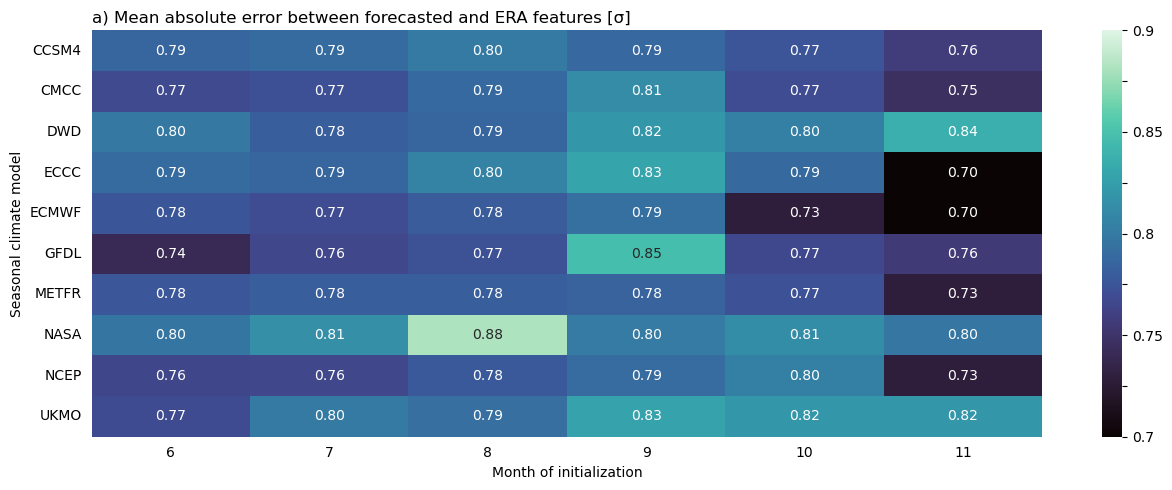

In [293]:
fig, axs = plt.subplots(1, 1, figsize=(13,5))


sns.heatmap(data_plot_mae, cmap="mako", cbar=True, ax=axs, vmin=0.7, vmax=0.9, annot=True, fmt=".2f")
axs.tick_params(left=False, bottom=False)
axs.set_title("a) Mean absolute error between forecasted and ERA features [\u03C3]", loc="left")
axs.set_xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=0, ha='center')
axs.set_xlabel("Month of initialization");
axs.set_ylabel("Seasonal climate model");
axs.collections[0].colorbar.set_ticklabels([.7, "", .75, "", .8, "", .85, "", .9])

"""
sns.heatmap(data_plot_wmae, cmap="mako", cbar=True, ax=axs[1], annot=True)
axs[1].tick_params(left=False, bottom=False)
axs[1].set_title("b) Weighted mean absolute error", loc="left")
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=0, ha='center')
axs[1].set_xlabel("");
axs[1].set_ylabel("");

sns.heatmap(data_plot_awse, cmap="mako", cbar=True, ax=axs[2], annot=True)
axs[2].tick_params(left=False, bottom=False)
axs[2].set_title("c) Absolute weighted sum of errors", loc="left")
axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=0, ha='center')
axs[2].set_xlabel("");
axs[2].set_ylabel("");
"""
plt.tight_layout()
plt.savefig("files/figures/figure5.png")
plt.show()


In [297]:
data_plot_mae.mean(axis=1)

model
CCSM4    0.782220
CMCC     0.775603
DWD      0.804270
ECCC     0.782732
ECMWF    0.757473
GFDL     0.774347
METFR    0.770492
NASA     0.817072
NCEP     0.771727
UKMO     0.804205
dtype: float64

### Build MME

In [294]:
li = []
for month in list(range(6, 12)):
    mme_models = data_plot_mae[month].sort_values()[:2].index.tolist()
    print("SCM: {} for IM {}".format("_".join(mme_models), month))
    mme = scm_era.loc[(scm_era["init_month"] == month) & (scm_era["model"].isin(mme_models))].groupby(["year", "init_month"])[features + ["yield anomaly [%]"]].mean().reset_index().assign(model="MME")
    li.append(mme)
scm_era_mme = pd.concat([scm_era, pd.concat(li, ignore_index=True)], ignore_index=True, axis=0)

SCM: GFDL_NCEP for IM 6
SCM: NCEP_GFDL for IM 7
SCM: GFDL_NCEP for IM 8
SCM: METFR_CCSM4 for IM 9
SCM: ECMWF_GFDL for IM 10
SCM: ECCC_ECMWF for IM 11


## EXPORT

In [295]:
scm_era_mme.to_csv("files/ERA/processed/era_scm_final_features.csv", index=False)